In [1]:
import math
import numpy as np

import mido
import librosa
import librosa.display

import IPython.display as ipd
import matplotlib.pyplot as plt
from torch import optim

In [2]:
y, sr = librosa.load('4Beats.wav')

NoBackendError: 

In [56]:
D = librosa.stft(y)

In [57]:
D.shape

(1025, 87)

In [79]:
print(D[:,1:2].shape)

y_hat2 = librosa.istft(np.abs(D.real))
y_hat_sign = librosa.istft(np.abs(D) * np.sign(D))
y_Short = librosa.istft(D[:,1:4])




(1025, 1)


In [80]:
#ipd.Audio(y_hat,rate=sr) # load a local WAV file
ipd.Audio(y_Short,rate=sr) # load a local WAV file

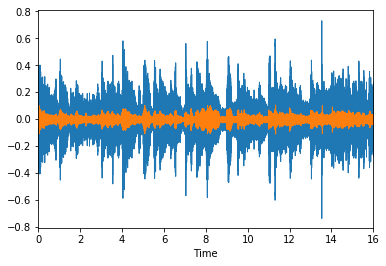

In [7]:
librosa.display.waveplot(y_hat_sign, sr=sr);
librosa.display.waveplot(y_hat2, sr=sr)

In [8]:
noteDict={}
mid = mido.MidiFile('4Beatsslow.mid')
for i, track in enumerate(mid.tracks):
    print('Track {}: {}'.format(i, track.name))
    for msg in track:
        print(msg.time)

Track 0: Inst 1
0
0
0
0
0
0
0
0
240
240
240
240
240
240
240
240


In [9]:
120*24

2880

In [11]:
bps = (60/(60000000/500000))
ticktime = bps/(24)
ticktime*240
print(bps,ticktime,(ticktime*240)/20)

0.5 0.020833333333333332 0.25


In [12]:
for msg in mido.MidiFile('4Beats.mid').play():
    print(msg)

note_on channel=0 note=48 velocity=80 time=0
note_off channel=0 note=48 velocity=64 time=0.25
note_on channel=0 note=48 velocity=80 time=0.25
note_off channel=0 note=48 velocity=64 time=0.25
note_on channel=0 note=48 velocity=80 time=0.25
note_off channel=0 note=48 velocity=64 time=0.25
note_on channel=0 note=48 velocity=80 time=0.25
note_off channel=0 note=48 velocity=64 time=0.25


In [13]:
for msg in mido.MidiFile('4Beatsslow.mid'):
    #time.sleep(msg.time)
    if not msg.is_meta:
        print(msg.note)

48
48
48
48
48
48
48
48


In [14]:
def noteToFreq(m):
    return 2**((m-69)/12) * 440

In [81]:
midiArray=[]
HopSize= 2048 / 22050 / 4
timeTracker=0.0
totalTimeTracker=0.0
MemoryArray=np.zeros(1025)
lasttime=0;
for msg in mido.MidiFile('4Beats.mid'):
    if not msg.is_meta:
        totalTimeTracker+=msg.time
        nextEventTime=lasttime+msg.time
        while nextEventTime> timeTracker + HopSize:
            midiArray.append(MemoryArray.copy())
            timeTracker += HopSize;
        if msg.type=='note_on':
            MemoryArray[math.floor(noteToFreq(msg.note)/10.864)]+=1.0;
        elif msg.type=='note_off':
            MemoryArray[math.floor(noteToFreq(msg.note)/10.864)]-=1.0;
        if timeTracker+msg.time == timeTracker + HopSize:
            midiArray.append(MemoryArray.copy())
            timeTracker += HopSize
        lasttime += msg.time
midiArray = np.array(midiArray)        

In [60]:
midiArray.shape

(75, 1025)

In [61]:
midifft = np.array(midiArray).T

In [62]:
len(midifft)

1025

In [63]:
midifft.shape

(1025, 75)

(75, 1025)


/Users/dg/anaconda3/envs/INFO6010/lib/python3.7/site-packages/matplotlib/image.py:855: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  self.axes.set_xlim((xmin, xmax), auto=None)


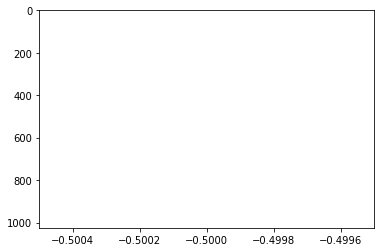

In [64]:
y_hat = librosa.istft(midifft)
npMidiArray=np.array(midiArray)
print(npMidiArray.shape)
plt.imshow(npMidiArray.T[:,100:200],aspect='auto',interpolation='none')

In [65]:
ipd.Audio(y_hat,rate=22050)

In [82]:
midiArray=[]
HopSize=0.023
timeTracker=0.0
totalTimeTracker=0.0
MemoryArray=np.zeros(127)
lasttime=0;
for msg in mido.MidiFile('4Beats.mid'):
    if not msg.is_meta:
        totalTimeTracker+=msg.time
        nextEventTime=lasttime+msg.time
        while nextEventTime> timeTracker + HopSize:
            midiArray.append(MemoryArray.copy())
            timeTracker += HopSize;
        if msg.type=='note_on':
            MemoryArray[msg.note]+=1.0;
        elif msg.type=='note_off':
            MemoryArray[msg.note]-=1.0;
        if(timeTracker+msg.time >= timeTracker + HopSize):
            midiArray.append(MemoryArray.copy())
            timeTracker += HopSize
        lasttime += msg.time
        

In [98]:
import torch.nn.functional as F
from torch import nn
import torch

In [54]:
## Solution

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 128, 64, 10 units each
        self.fc1 = nn.Linear(127, 500)
        self.fc2 = nn.Linear(500, 700)
        # Output layer, 10 units - one for each digit
        self.fc3 = nn.Linear(700, 1025)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

model = Network()
model

Network(
  (fc1): Linear(in_features=127, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=700, bias=True)
  (fc3): Linear(in_features=700, out_features=1025, bias=True)
)

In [123]:
midiArray=np.float32(np.array(midiArray))
midiArray.shape
D_t=D.T
D_t.shape

(87, 1025)

In [139]:
D_data=D_t[:midiArray.shape[0]].real;
print(midiArray.shape,D_data.shape)
print(midiArray.dtype,D_data.dtype)

(77, 127) (77, 1025)
float32 float32


In [163]:
import torch.utils.data as utils


tensor_x = torch.stack([torch.Tensor(i) for i in np.abs(midiArray)/np.max(np.abs(midiArray))]) # transform to torch tensors
tensor_y = torch.stack([torch.Tensor(i) for i in np.abs(D_data)/np.max(np.abs(D_data))])
print(tensor_x.shape,tensor_y.shape)
my_dataset = utils.TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = utils.DataLoader(my_dataset) # create your dataloader

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

criterion = nn.L1Loss()
# Get our data


torch.Size([77, 127]) torch.Size([77, 1025])


In [167]:


data, labels = next(iter(my_dataloader))

optimizer.zero_grad()

# Forward pass, get our logits
logits = model(data)
print(labels.shape,logits.shape)
# Calculate the loss with the logits and the labels
x=criterion(logits,labels)

x.backward()
print(loss,x)
optimizer.step()

torch.Size([1, 1025]) torch.Size([1, 1025])
tensor(12251.9238, grad_fn=<SumBackward0>) tensor(0.0508, grad_fn=<L1LossBackward>)


In [ ]:
epochs = 500
LossOverEpoch=[]
for e in range(epochs):
    running_loss = 0
    for data, labels in my_dataloader:
        # Flatten MNIST images into a 784 long vector
        
        # TODO: Training pass
        optimizer.zero_grad()
        
        logits = model(data)
        loss =criterion(logits,labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        LossOverEpoch.append(running_loss)
        print(f"Training loss: {running_loss/len(my_dataloader)}")

Training loss: 0.0034061144347992036
Training loss: 0.0034023445801107913
Training loss: 0.003398601727729494
Training loss: 0.003394991966786903
Training loss: 0.003391418358093345
Training loss: 0.0033880072878673673
Training loss: 0.0033845971943205827
Training loss: 0.0033812173203770796
Training loss: 0.0033779832679633197
Training loss: 0.0033747563894547814
Training loss: 0.0033717082402148803
Training loss: 0.003368739141514162
Training loss: 0.0033657453446225686
Training loss: 0.003362889772027054
Training loss: 0.0033600510539511194
Training loss: 0.0033572982912036505
Training loss: 0.003354621029083992
Training loss: 0.0033520356020224945
Training loss: 0.0033494413425154113
Training loss: 0.0033469173101732482
Training loss: 0.0033444820074727396
Training loss: 0.003342052321433537
Training loss: 0.0033396167450814277
Training loss: 0.003337364401910212
Training loss: 0.0033350937074509922
Training loss: 0.0033328488874309636
Training loss: 0.0033306293144168986
Training 

Training loss: 0.003226600528404407
Training loss: 0.0032265510511366867
Training loss: 0.003226484581767642
Training loss: 0.0032264647972104804
Training loss: 0.003226388977574451
Training loss: 0.003226384210593805
Training loss: 0.0032262933854763577
Training loss: 0.0032262014045210726
Training loss: 0.0032262404028979407
Training loss: 0.0032262152730632427
Training loss: 0.0032260808481399403
Training loss: 0.003226054796809935
Training loss: 0.0032259732403175593
Training loss: 0.0032259277725749493
Training loss: 0.0032259093729065515
Training loss: 0.0032258659923243543
Training loss: 0.0032258048863754935
Training loss: 0.0032257417053613183
Training loss: 0.0032257027508291814
Training loss: 0.0032256176111639125
Training loss: 0.003225605946197477
Training loss: 0.0032255585696971552
Training loss: 0.003225531921171668
Training loss: 0.003225431104747022
Training loss: 0.003225374729493512
Training loss: 0.0032253779989497907
Training loss: 0.0032253068797713654
Training l

Training loss: 0.00321752578473662
Training loss: 0.0032175253470452477
Training loss: 0.0032174430210022377
Training loss: 0.0032173924377889604
Training loss: 0.0032174097549460537
Training loss: 0.003217361398742764
Training loss: 0.0032173487102286286


In [ ]:
plt.plot(LossOverEpoch)
plt.show()